## Correlation

Correlation Feature Selection evaluates subsets of features on the basis of the following hypothesis: "Good feature subsets contain features highly correlated with the target, yet uncorrelated to each other".

**References**:

M. Hall 1999, [Correlation-based Feature Selection for Machine Learning](http://www.cs.waikato.ac.nz/~mhall/thesis.pdf)

Senliol, Baris, et al. "Fast Correlation Based Filter (FCBF) with a different search strategy." Computer and Information Sciences.



I will demonstrate how to select features based on correlation using 2 procedures. The first one is a brute force function that finds correlated features without any further insight. The second procedure finds groups of correlated features. Often, more than 2 features are correlated with each other. We can find groups of 3, 4 or more features that are correlated. By identifying these groups, we can then select from each group, which feature we want to keep, and which ones we want to remove.

I will use the Paribas claims dataset from Kaggle.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

In [25]:
# load dataset
data = pd.read_csv('Advertising.csv', nrows=50000)
data.shape

(200, 8)

In [26]:
data.head()

,Unnamed: 0,TV,radio,radio1,Constant,Quase,newspaper,sales
0,1,230.1,37.8,37.8,1,1,69.2,22.1
1,2,44.5,39.3,39.3,1,1,45.1,10.4
2,3,17.2,45.9,45.9,1,1,69.3,9.3
3,4,151.5,41.3,41.3,1,1,58.5,18.5
4,5,180.8,10.8,10.8,1,1,58.4,12.9


In [27]:
# In practice, feature selection should be done after data pre-processing,
# so ideally, all the categorical variables are encoded into numbers,
# and then you can assess whether they are correlated with other features

# here for simplicity I will use only numerical variables
# select numerical columns:

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_vars = list(data.select_dtypes(include=numerics).columns)
data = data[numerical_vars]
data.shape

(200, 8)

### Important

In all feature selection procedures, it is good practice to select the features by examining only the training set. And this is to avoid overfit.

In [28]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['sales','radio1','Constant','Quase', 'Unnamed: 0'], axis=1),
    data['sales'],
    test_size=0.2,
    random_state=0)

X_train.shape, X_test.shape

((160, 3), (40, 3))

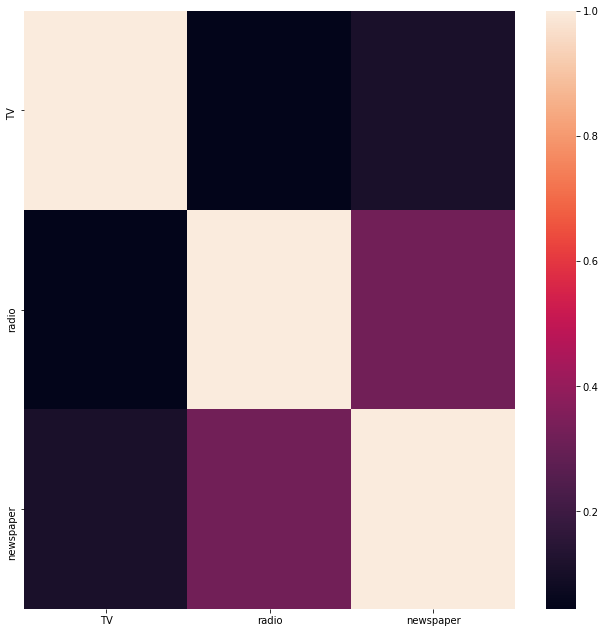

In [29]:
# visualise correlated features
# I will build the correlation matrix, which examines the 
# correlation of all features (for all possible feature combinations)
# and then visualise the correlation matrix using seaborn

corrmat = X_train.corr()
fig, ax = plt.subplots()
fig.set_size_inches(11,11)
sns.heatmap(corrmat)

In the plot above, the red squares correspond to highly correlated features (>0.8). We can see that there are quite a few. The diagonal represents the correlation of a feature with itself, therefore the value is 1.

### Brute force approach

In [30]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything else
# without any other insight.

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [31]:
corr_features = correlation(X_train, 0.8)
len(set(corr_features))

0

We can see that 55 features are highly correlated with other features in the training set. Very likely, by removing these correlated features, the performance of your machine learning models will drop very little, if at all. We can go ahead and drop the features like we have done in previous lectures.

In [32]:
X_train.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)

X_train.shape, X_test.shape

((160, 3), (40, 3))

By removing correlated columns we reduced the feature space from 112 numerical columns to 57, almost half of the original set.

### Second approach

The second approach looks to identify groups of highly correlated features. And then, we can make further investigation within these groups to decide which feature we keep and which one we remove.

In [40]:
# load dataset
data = pd.read_csv('Advertising.csv', nrows=50000)

# select numerical variables
data = data[numerical_vars]

# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['sales','radio1','Constant','Quase', 'Unnamed: 0'], axis=1),
    data['sales'],
    test_size=0.3,
    random_state=0)

In [41]:
# build a dataframe with the correlation between features
# remember that the absolute value of the correlation
# coefficient is important and not the sign

corrmat = X_train.corr()
corrmat = corrmat.abs().unstack() # absolute value of corr coef
corrmat = corrmat.sort_values(ascending=False)
corrmat = corrmat[corrmat >= 0.8]
corrmat = corrmat[corrmat < 1]
corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ['feature1', 'feature2', 'corr']
corrmat.head()

,feature1,feature2,corr


In [42]:
# find groups of correlated features

grouped_feature_ls = []
correlated_groups = []

for feature in corrmat.feature1.unique():
    if feature not in grouped_feature_ls:

        # find all features correlated to a single feature
        correlated_block = corrmat[corrmat.feature1 == feature]
        grouped_feature_ls = grouped_feature_ls + list(
            correlated_block.feature2.unique()) + [feature]

        # append the block of features to the list
        correlated_groups.append(correlated_block)

print('found {} correlated groups'.format(len(correlated_groups)))
print('out of {} total features'.format(X_train.shape[1]))

found 0 correlated groups
out of 3 total features


In [43]:
# now we can visualise each group. We see that some groups contain
# only 2 correlated features, some other groups present several features 
# that are correlated among themselves.

for group in correlated_groups:
    print(group)
    print()

In [47]:
# we can now investigate further features within one group.
# let's for example select group 3

group = correlated_groups[0]
group

IndexError: list index out of range

In [45]:
# we could select the features with less missing data
# like this:

for feature in list(group.feature2.unique())+['v17']:
    print(X_train[feature].isnull().sum())

KeyError: 'v76'

All features show similar number of missing data in this case.

Alternatively, we could build a machine learning algorithm using all the features from the above list, and select the more predictive one.

In [15]:
from sklearn.ensemble import RandomForestClassifier

features = list(group.feature2.unique())+['v17']
rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
rf.fit(X_train[features].fillna(0), y_train)

RandomForestClassifier(max_depth=4, n_estimators=200, random_state=39)

In [17]:
# we get the feature importance attributed by the 
# random forest model (more on this in coming lectures)

importance = pd.concat(
    [pd.Series(features),
     pd.Series(rf.feature_importances_)], axis=1)

importance.columns = ['feature', 'importance']
importance.sort_values(by='importance', ascending=False)

,feature,importance
2,v48,0.173981
3,v93,0.154484
6,v101,0.129764
1,v64,0.118110
7,v17,0.117571
4,v106,0.113958
0,v76,0.108071
5,v44,0.084062


In this case, feature v48 shows the higher importance according to random forests. Then, I would select v48, and remove all the remaining features from this group from the dataset.

**Note**

None of the 2 procedures for removing correlated features are perfect, and some correlated features may escape the loops of code. So it might be worthwhile to check that after removing the correlated features, there are no correlated features left in the dataset. If there are, repeat the procedure to remove the remaining ones.

That is all for this lecture, I hope you enjoyed it and see you in the next one!